In [ ]:
import MetaTrader5 as mt
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd
import plotly.express as px
import nbformat
import matplotlib.pyplot as plt
import numpy as np
import time

In [125]:
mt.initialize()

True

In [ ]:
login = 52238446
password = 'Gpo9y&rAhpYOY!'
server = 'ICTrading-Demo'

# in metatrader: 
# Raw Trading (Mauritius) Ltd
# ICTrading-Demo
# Tools > Expert Advisors > allow algorithmic trading
# Add the symbol/ticker to you are using to metatrader: Symbols > click to add...

In [127]:
mt.login(login, password, server)

True

In [128]:
account_info = mt.account_info()
account_info

AccountInfo(login=52238446, trade_mode=0, leverage=1, limit_orders=200, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=9987.64, credit=0.0, profit=-1.63, equity=9986.01, margin=1000.0, margin_free=8986.01, margin_level=998.601, margin_so_call=100.0, margin_so_so=50.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Archer Fish', server='ICTrading-Demo', currency='CAD', company='Raw Trading (Mauritius) Ltd')

In [ ]:
ticker = 'CADCHF'
interval =  mt.TIMEFRAME_D1
from_date = datetime.now()
no_of_rows = 1024

rates = mt.copy_rates_from(ticker, interval, from_date, no_of_rows)

In [130]:
ohlc = pd.DataFrame(rates)
ohlc['time'] = pd.to_datetime(ohlc['time'], unit='s')

In [131]:
ohlc = ohlc.drop(columns=[col for col in ['spread', 'real_volume'] if col in ohlc.columns])

for lag in range(1, 2):
    ohlc[f'open_lag{lag}'] = ohlc['open'].shift(lag)
    ohlc[f'high_lag{lag}'] = ohlc['high'].shift(lag)
    ohlc[f'low_lag{lag}'] = ohlc['low'].shift(lag)
    ohlc[f'close_lag{lag}'] = ohlc['close'].shift(lag)
    ohlc[f'tick_volume_lag{lag}'] = ohlc['tick_volume'].shift(lag)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.017532
5d_close_future_pct     -0.017532             1.000000


C:\Users\Yuchen xin\AppData\Local\Temp\ipykernel_13520\2321125509.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ohlc['5d_close_future_pct'] = ohlc['5d_future_close'].pct_change(5)


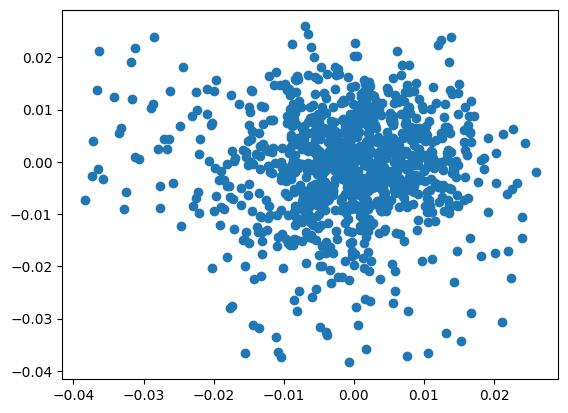

In [132]:
# Create 5-day % changes of close for the current day, and 5 days in the future
ohlc['5d_future_close'] = ohlc['close'].shift(-5)
ohlc['5d_close_future_pct'] = ohlc['5d_future_close'].pct_change(5)
ohlc['5d_close_pct'] = ohlc['close'].pct_change(5)

# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = ohlc[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(ohlc['5d_close_pct'], ohlc['5d_close_future_pct'])
plt.show()

In [133]:
feature_names = ['5d_close_pct']  # Initialize the feature list

# Define a simple RSI function using pandas
def compute_rsi(series, period):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Create moving averages and RSI for time periods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:
    # Moving Average normalized by current price
    ohlc[f'ma{n}'] = ohlc['close'].rolling(window=n).mean() / ohlc['close']

    # RSI
    ohlc[f'rsi{n}'] = compute_rsi(ohlc['close'], period=n)

    # Update feature list
    feature_names += [f'ma{n}', f'rsi{n}']

print(feature_names)


['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [134]:
# Drop all na values
ohlc = ohlc.dropna()
ohlc

,time,open,high,low,close,tick_volume,open_lag1,high_lag1,low_lag1,close_lag1,...,5d_close_future_pct,5d_close_pct,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200
199,2022-02-17,0.72648,0.72684,0.72368,0.72395,58486,0.72663,0.73049,0.72589,0.72640,...,-0.002832,-0.004675,1.003922,39.312807,1.005796,50.074206,1.000334,48.798404,1.010900,47.892161
200,2022-02-18,0.72373,0.72725,0.72184,0.72198,53515,0.72648,0.72684,0.72368,0.72395,...,0.009169,-0.005126,1.005917,34.081287,1.008344,46.811053,1.003020,49.281070,1.013502,47.698925
201,2022-02-21,0.72160,0.72340,0.71775,0.71795,38555,0.72373,0.72725,0.72184,0.72198,...,0.008009,-0.011701,1.010768,33.402490,1.013395,40.084643,1.008590,49.020680,1.018980,46.887669
202,2022-02-22,0.71778,0.72494,0.71705,0.72171,62318,0.72160,0.72340,0.71775,0.71795,...,-0.001247,-0.008027,1.005142,43.323551,1.007542,40.720802,1.003427,51.479925,1.013514,47.685878
203,2022-02-23,0.72003,0.72520,0.71998,0.72090,42346,0.71778,0.72494,0.71705,0.72171,...,0.010473,-0.007572,1.005780,41.022851,1.008221,42.374728,1.004569,50.225958,1.014487,47.553235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,2025-04-10,0.60793,0.60983,0.58895,0.58910,114728,0.59380,0.60930,0.58920,0.60923,...,0.005585,-0.033470,1.036274,32.242672,1.040672,35.095230,1.053619,37.514754,1.066621,42.447785
1015,2025-04-11,0.58875,0.59098,0.58307,0.58750,136122,0.60793,0.60983,0.58895,0.58910,...,0.002468,-0.027962,1.035585,30.412371,1.041433,34.146130,1.055163,37.309247,1.068901,42.301639
1016,2025-04-14,0.58933,0.59514,0.58490,0.58717,79952,0.58875,0.59098,0.58307,0.58750,...,-0.004632,-0.027639,1.032402,28.599087,1.040205,35.562585,1.054274,35.430752,1.068872,42.240873
1017,2025-04-15,0.58620,0.59050,0.58560,0.58970,56776,0.58933,0.59514,0.58490,0.58717,...,0.005426,-0.007222,1.024396,29.974230,1.034158,37.466452,1.048323,36.042965,1.063720,42.956485


In [135]:
# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = ohlc[feature_names]
targets = ohlc['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = ohlc[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14     rsi14  \
5d_close_future_pct             1.000000      0.016156  0.043954 -0.107200   
5d_close_pct                    0.016156      1.000000 -0.861790  0.563963   
ma14                            0.043954     -0.861790  1.000000 -0.804835   
rsi14                          -0.107200      0.563963 -0.804835  1.000000   
ma30                            0.094138     -0.652281  0.853617 -0.865179   
rsi30                          -0.059917      0.387063 -0.535548  0.621772   
ma50                            0.078305     -0.545075  0.726680 -0.763392   
rsi50                          -0.101987      0.301366 -0.428357  0.511656   
ma200                           0.088264     -0.294132  0.400987 -0.451928   
rsi200                         -0.076755      0.176835 -0.232878  0.269259   

                         ma30     rsi30      ma50     rsi50     ma200  \
5d_close_future_pct  0.094138 -0.059917  0.078305 -0.101987  0.08826

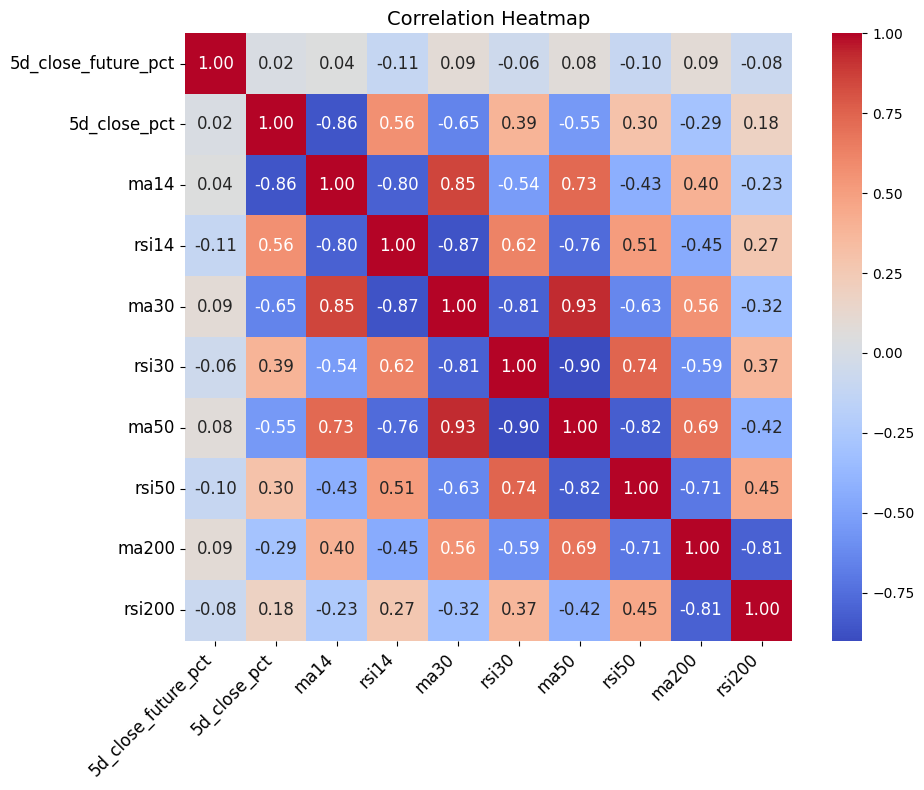

In [137]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))  # Set figure size to prevent overlap
sns.heatmap(corr, annot=True, annot_kws={"size": 12}, cmap='coolwarm', fmt=".2f", square=True)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
fig = px.line(ohlc, x=ohlc['time'], y=ohlc['close'])
fig.show()

In [10]:
ticker = 'CADCHF'
qty = 0.01
buy_order_type = mt.ORDER_TYPE_BUY
sell_order_type = mt.ORDER_TYPE_SELL
buy_price = mt.symbol_info_tick("CADCHF").ask
sell_price = mt.symbol_info_tick("CADCHF").bid
sl_pct = 0.05
tp_pct = 0.1
buy_sl = buy_price * (1-sl_pct)
buy_tp = buy_price * (1+tp_pct)
sell_sl = sell_price * (1+sl_pct)
sell_tp = sell_price * (1-tp_pct)

In [11]:
def create_order(ticker, qty, order_type, price, sl, tp):
    request = {
        "action": mt.TRADE_ACTION_DEAL,
        "symbol": ticker,
        "volume": qty,
        "type": order_type,
        "price": price,
        "sl": sl,
        "tp": tp,
        "comment": "python open position",
        "type_time": mt.ORDER_TIME_GTC,
        "type_filling": mt.ORDER_FILLING_IOC
    }
    
    # send a trading request
    order = mt.order_send(request)
    return order

In [12]:
def close_order(ticker, qty, order_type, price):
    request = {
        "action": mt.TRADE_ACTION_DEAL,
        "symbol": ticker,
        "volume": qty,
        "type": order_type,
        "position": mt.positions_get()[0]._asdict()['ticket'],
        "price": price,
        "comment": "python script close",
        "type_time": mt.ORDER_TIME_GTC,
        "type_filling": mt.ORDER_FILLING_IOC
    }

    # send a trading request
    order = mt.order_send(request)
    return order

In [13]:
# create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)

In [14]:
# close_order(ticker, qty, sell_order_type, sell_price)

In [ ]:
for i in range(15):
    start_date = datetime.now() - timedelta(days=30)
    ohlc = pd.DataFrame(mt.copy_rates_range('CADCHF', mt.TIMEFRAME_M1, start_date, datetime.now()))
    ohlc['time'] = pd.to_datetime(ohlc['time'], unit='s')
    print(ohlc)

    current_close = list(ohlc[-1:]['close'])[0]
    last_close = list(ohlc[-2:]['close'])[0]
    last_high = list(ohlc[-2:]['high'])[0]
    last_low = list(ohlc[-2:]['low'])[0]

    long_condition = current_close > last_high
    short_condition = current_close < last_low
    close_long_condition = current_close < last_close
    close_short_condition = current_close > last_close

    already_buy = False
    already_sell = False

    try:
        already_sell = mt.positions_get()[0]._asdict()['type'] == 1
        already_buy = mt.positions_get()[0]._asdict()['type'] == 0
    except:
        pass

    no_positions = len(mt.positions_get()) == 0

    if long_condition:
        if no_positions:
            create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)
            print("Buy Order Placed")
        if already_sell:
            close_order(ticker, qty, buy_order_type, buy_price)
            print("Sell Position Closed")
            time.sleep(1)
            create_order(ticker, qty, buy_order_type, buy_price, buy_sl, buy_tp)
            print("Buy Order Placed")
    if short_condition:
        if no_positions:
            create_order(ticker, qty, sell_order_type, sell_price, sell_sl, sell_tp)
            print("Sell Order Placed")
        if already_buy:
            close_order(ticker, qty, sell_order_type, sell_price)
            print("Buy Position Closed")
            time.sleep(1)
            create_order(ticker, qty, sell_order_type, sell_price, sell_sl, sell_tp)
            print("Sell Order Placed")


    try:
        already_sell = mt.positions_get()[0]._asdict()['type'] == 1
        already_buy = mt.positions_get()[0]._asdict()['type'] == 0
    except:
        pass


    if close_long_condition and already_buy:
        close_order(ticker, qty, sell_order_type, sell_price)
        print("Only Buy Position Closed")
    if close_short_condition and already_sell:
        close_order(ticker, qty, buy_order_type, buy_price)
        print("Only Sell Position Closed")

    already_buy = False
    already_sell = False
    time.sleep(60)

                     time     open     high      low    close  tick_volume  \
0     2025-03-24 00:13:00  0.61451  0.61452  0.61451  0.61452            2   
1     2025-03-24 00:14:00  0.61452  0.61452  0.61452  0.61452            1   
2     2025-03-24 00:15:00  0.61452  0.61452  0.61445  0.61451           13   
3     2025-03-24 00:16:00  0.61451  0.61453  0.61449  0.61453            4   
4     2025-03-24 00:17:00  0.61453  0.61454  0.61453  0.61454            2   
...                   ...      ...      ...      ...      ...          ...   
31621 2025-04-23 00:06:00  0.59160  0.59160  0.59155  0.59155            2   
31622 2025-04-23 00:09:00  0.59155  0.59155  0.59155  0.59155            1   
31623 2025-04-23 00:10:00  0.59155  0.59155  0.59145  0.59145            2   
31624 2025-04-23 00:11:00  0.59145  0.59145  0.59145  0.59145            1   
31625 2025-04-23 00:12:00  0.59140  0.59140  0.59140  0.59140            1   

       spread  real_volume  
0         134            0  
1    